# STM32 RF Spectrum Analysis

## Load spectrum files

In [1]:
import pandas as pd
import numpy as np
import glob

In [2]:
spectrum_input = []
spectrum_output = []
spectrum_files = glob.glob("SignalHound/stm32_*")
spectrum_labels = {'66':0,'333':1,'1k':2,'idle':3}

for f in spectrum_files:
    # read the label from file name
    label = f.split('_')[1].rstrip('.csv')
    label = spectrum_labels[label]
    
    # read the spectrum
    spectrum = pd.read_csv(f,names=['freq','amp'])
    spectrum = spectrum['amp'].values.tolist()
    
    # append to the result container
    spectrum_input.append(list(spectrum))
    spectrum_output.append(label)
    
# convert to numpy array
spectrum_input = np.array(spectrum_input,dtype=np.float32)
spectrum_output = np.array(spectrum_output,dtype=np.uint8)

## Cross Validation

In [3]:
from sklearn.decomposition import NMF,TruncatedSVD,PCA
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [4]:
def plot_cm(cm,title='Confusion matrix'):
    plt.ylabel('Actual label', size = 15)
    plt.xlabel('Predicted label', size = 15)
    plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    plt.xticks(tick_marks, rotation=45)
    plt.yticks(tick_marks)

    width, height = cm.shape
    for x in range(width):
      for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

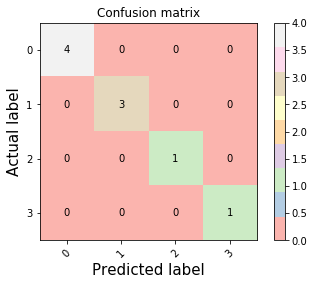

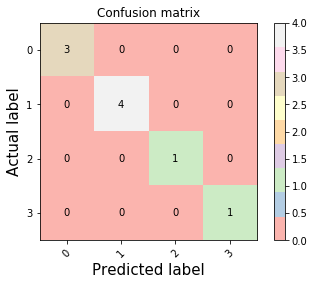

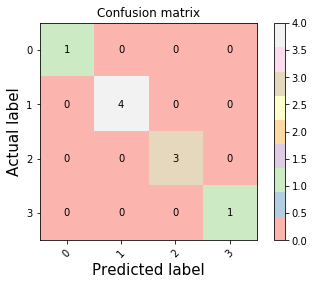

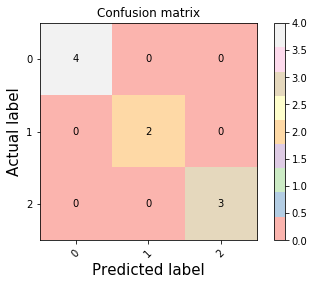

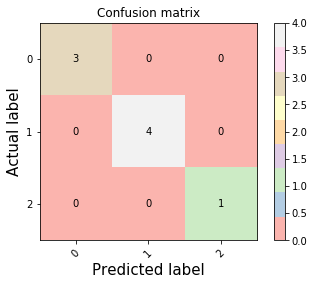

In [5]:
kf = KFold(n_splits=5,shuffle=True,random_state=42)

for train_index,test_index in kf.split(spectrum_input):
    # split into train and test set
    train_x = spectrum_input[train_index]
    train_y = spectrum_output[train_index]
    test_x = spectrum_input[test_index]
    test_y = spectrum_output[test_index]
    
    # dimentionality reduction
    pca = PCA();
    train_x = pca.fit_transform(train_x)
    test_x = pca.transform(test_x)
    
    # classification
    svm = SVC(kernel='linear',C=1000) # hard-margin SVM
    svm.fit(train_x,train_y)
    predicted = svm.predict(test_x)
    
    # plot the confusion matrix
    plt.figure()
    plot_cm(metrics.confusion_matrix(test_y, predicted))